In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import shap
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF,ConstantKernel

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
alpha=10                       #alpha parameter for feature selection
covariation=0.99
NNB_radius=12    
N5_radius=5
CV=5                           #cross validation for hyperparameters tuning
opt="neg_mean_absolute_error"  #evaluation metric for hyperparameters tuning
n_jobs=4                       #number of processes in parallel
file_input_name ="chains"      #or proteins 

In [9]:
models_dict={"LR":[LinearRegression(),{}],
             'GPR':[GaussianProcessRegressor(ConstantKernel(1.0,constant_value_bounds="fixed") * RBF(1.0,length_scale_bounds="fixed")),                    
                    {
                    'regressor__alpha':np.logspace(-2, 2, 5),
                    'regressor__kernel__k1__constant_value': np.logspace(-2, 2, 5),
                    'regressor__kernel__k2__length_scale': np.logspace(-2, 2, 5)
                    }],
             'SVR':[SVR(RBF()),                   
                    {
                    'regressor__C': np.logspace(-3,3,7),
                    'regressor__gamma': np.logspace(-3,3,7)
                    #'regressor__epsilon': np.logspace(-1,0,2)
                    }],
             'KNR':[KNeighborsRegressor(),
                    {           
                    'regressor__n_neighbors': [2, 3, 4, 5, 6, 7],
                    'regressor__metric': ['euclidean','manhattan'],
                    'regressor__weights':  ["uniform", "distance"]
                    }],
             "RF":[RandomForestRegressor(),
                   {
                    'regressor__n_estimators': [100,150,200],
                    'regressor__max_features': ['auto', 'sqrt','log2'],
                    'regressor__max_depth': [3, 4, 5]
                    }],
             "XGB":[XGBRegressor(),
                    {
                    "regressor__learning_rate" : [0.01,0.1,0.2,0.4],
                    "regressor__max_depth" : [3,4,5],
                    "regressor__min_child_weight" : [1,5,10],
                    "regressor__n_estimators" : [100,150,200]
                    }]
             } 
#add dict for selector in gridsearch
for estimator in models_dict.keys():
    #models_dict[estimator][1]["selector__estimator__alpha"]=[10]
    models_dict[estimator][1]["selector__estimator__l1_ratio"]=[0.5,0.75,1]

name_models=["GPR"] #which is the best model obtained by the estimator scan?

In [5]:
path_dir1="G:/Altri computer/Computer_Laboratorio/"
#path_dir1="C:/Users/AM866527/Desktop/"
file_name= "dataset_" + file_input_name + "_"+ str(NNB_radius) + "_" + str(N5_radius) + ".xlsx"                 
df=pd.read_excel(path_dir1+"AntonioM/Dataset_finali/"+file_name,sheet_name="Sheet1",index_col=0)

In [6]:
df=df.reset_index()
df=df.iloc[:,1:]
if "Protein_name" in df.columns:
    df=df.drop(["Protein_name"],axis=1) 
    
columns_to_keep_=[el for el in df.columns if "%" not in el and "_mean" not in el]
df=df.loc[:,columns_to_keep_]

columns_to_remove=[el for el in df.columns[0:-1] if df[el].std()==0]

df.drop(columns_to_remove,axis=1,inplace=True)

df_corr=df.corr().abs()
upper_tri = df_corr.where(np.triu(np.ones(df_corr.shape),k=1).astype(np.bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= covariation)]
df=df.drop(columns=to_drop,axis=1)

In [7]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [10]:
estimator_feature=ElasticNet(max_iter=1000,alpha=alpha)
for estimator in name_models:
    pipe = Pipeline([
                      ('scaler', StandardScaler()),
                      ('selector', SelectFromModel(estimator=estimator_feature)),
                      ('regressor', models_dict[estimator][0])
                    ])


    optEstimator = GridSearchCV(pipe, models_dict[estimator][1],
                                scoring=opt,cv=CV,n_jobs=n_jobs
                                )


    best_model=optEstimator.fit(X,y)
    best_params=best_model.best_params_
    l1_ratio=best_model.best_params_["selector__estimator__l1_ratio"]

    X_scaling=StandardScaler().fit(X).transform(X)     
    selection=ElasticNet(max_iter=1000,l1_ratio=l1_ratio,alpha=alpha).fit(X_scaling,y)     
    C=np.array(np.abs(selection.coef_)>0)

In [11]:
selected_features=[]
for el,el2 in zip(df.columns[1:],C):
    if el2==True:
        selected_features.append(el) 

In [12]:
X2=X[:,C]
X2_df=pd.DataFrame(X2,columns=selected_features)

In [13]:
X2_df

,pH,Oxygen_H_bond,Stacking_Alifatico,ASN,CYS,HIS,NNB.LEU,TYR,Nitrogen_around,nNats in side chain,N5.Vol / P(sheet),N5.log(Solub) x Flex,N3_amm.Hydrophobicity x Flex.,ResAromatici,Protein.FormalCharge,NNB.RESNEG,_SolventAccessibilityC2
0,7.2,2.0,2.0,1.0,3.0,0.0,0.0,4.0,9.0,7.0,472.195122,-19.173878,23.142,7.0,-24.0,2.0,0.343
1,7.2,2.0,2.0,1.0,3.0,0.0,0.0,4.0,10.0,7.0,472.195122,-19.173878,-2.524,6.0,-24.0,3.0,0.343
2,7.2,3.0,2.0,1.0,3.0,0.0,0.0,4.0,9.0,7.0,472.195122,-19.173878,23.142,7.0,-22.0,1.0,0.337
3,7.0,4.0,3.0,1.0,3.0,0.0,0.0,2.0,8.0,3.0,385.217391,4.880598,-1.270,4.0,-19.0,1.0,0.313
4,7.0,2.0,2.0,2.0,3.0,0.0,0.0,2.0,9.0,4.0,518.636364,-14.424928,-18.850,4.0,-19.0,2.0,0.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,7.2,4.0,4.0,1.0,2.0,1.0,1.0,5.0,16.0,21.0,400.666667,20.577566,7.800,11.0,-12.0,0.0,0.257
256,7.2,4.0,4.0,1.0,2.0,1.0,1.0,5.0,14.0,22.0,400.666667,20.577566,7.800,14.0,-13.0,0.0,0.260
257,7.2,4.0,4.0,1.0,2.0,1.0,0.0,5.0,15.0,22.0,400.666667,20.577566,7.800,14.0,-13.0,0.0,0.260
258,7.0,5.0,1.0,2.0,1.0,1.0,1.0,2.0,10.0,6.0,472.195122,-19.173878,8.572,5.0,-5.0,2.0,0.329


In [14]:
r=best_model.best_estimator_
r.fit(X2,y)
subset=shap.sample(X2,100)
explainer=shap.KernelExplainer(r.predict,(subset))
shap_values = explainer.shap_values(subset)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X2_df.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
features_graph=feature_importance["col_name"]

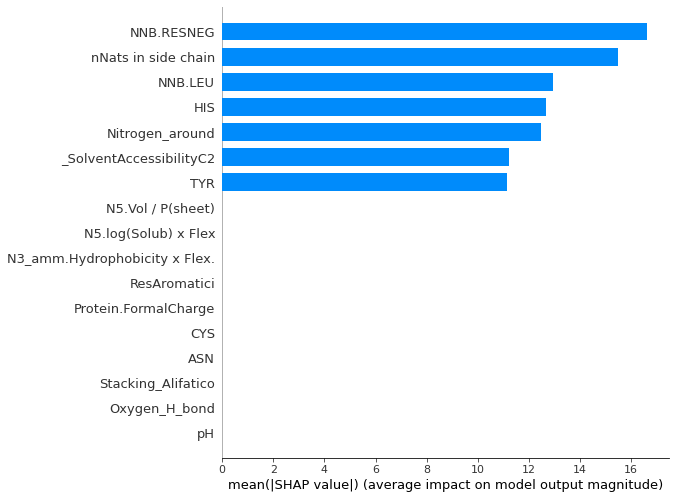

In [16]:
shap.summary_plot(shap_values, X2, plot_type='bar',feature_names=features_graph,max_display=len(features_graph))

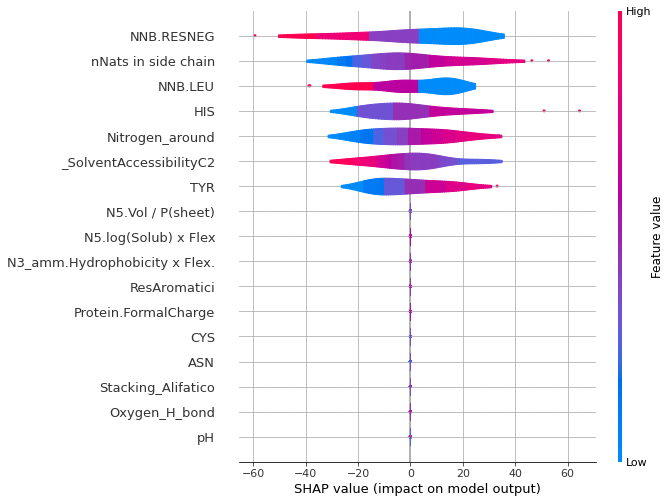

In [18]:
plt.grid(b=None)
shap.summary_plot(shap_values, subset ,feature_names=features_graph,max_display=len(features_graph),plot_type="violin")

In [19]:
shap.initjs()
shap.force_plot(
                explainer.expected_value,
                shap_values,
                subset,
                feature_names=features_graph
               )